# 0. Imports, config & paths

In [1]:
import os, json, random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

print("TF:", tf.__version__)
print("Keras:", keras.__version__)

from keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
print("Global policy:", mixed_precision.global_policy())

# ========= Common config =========
IMG_SIZE = (224, 224)     
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

# Backbone model (dataset project-hybrid-model)
MODEL_ROOT = "/kaggle/input/project-hybrid-model"
MODEL_PATH = os.path.join(MODEL_ROOT, "emb_hybrid_b4_supervised.keras")

# Emotion labels (suit for both FER & RAF)
EMO_LABELS = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
NUM_EMO = len(EMO_LABELS)

from tensorflow.keras.applications.efficientnet import preprocess_input

2025-11-18 19:43:39.258332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763495019.462543      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763495019.512301      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TF: 2.18.0
Keras: 3.8.0
Global policy: <DTypePolicy "mixed_float16">


# 1. Import model_layers.py & load backbone

In [2]:
import sys
from keras.saving import register_keras_serializable

sys.path.append(MODEL_ROOT)

from model_layers import TransformerBlock, avg_fn, sp_out_shape

try:
    from model_layers import max_fn
except ImportError:
    max_fn = None

TransformerBlock = register_keras_serializable(package="custom")(TransformerBlock)
avg_fn           = register_keras_serializable(package="custom")(avg_fn)
sp_out_shape     = register_keras_serializable(package="custom")(sp_out_shape)
if max_fn is not None:
    max_fn = register_keras_serializable(package="custom")(max_fn)

custom_objects = {
    "TransformerBlock": TransformerBlock,
    "avg_fn": avg_fn,
    "sp_out_shape": sp_out_shape,
}
if max_fn is not None:
    custom_objects["max_fn"] = max_fn

# Load backbone hybrid B4 + ViT + CBAM
base_model = keras.models.load_model(
    MODEL_PATH,
    custom_objects=custom_objects,
    compile=False,
)
print("Loaded backbone:", MODEL_PATH)

I0000 00:00:1763495035.243103      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'vit_head_block_0', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'vit_head_block_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause fail

Loaded backbone: /kaggle/input/project-hybrid-model/emb_hybrid_b4_supervised.keras


# 2. Helper for FER & RAF datasets

In [3]:
# ========= FER2013 PATHS =========
FER_ROOT = "/kaggle/input/fer2013"
FER_TRAIN_DIR = os.path.join(FER_ROOT, "train")
FER_TEST_DIR  = os.path.join(FER_ROOT, "test")  # dùng làm val

print("FER train dir:", FER_TRAIN_DIR)
print("FER test dir :", FER_TEST_DIR)

# ========= RAF-DB PATHS =========
RAF_ROOT = "/kaggle/input/raf-db-dataset"
RAF_DATA_ROOT = os.path.join(RAF_ROOT, "DATASET")

RAF_TRAIN_IMG_DIR = os.path.join(RAF_DATA_ROOT, "train")
RAF_TEST_IMG_DIR  = os.path.join(RAF_DATA_ROOT, "test")

RAF_TRAIN_CSV = os.path.join(RAF_ROOT, "train_labels.csv")
RAF_TEST_CSV  = os.path.join(RAF_ROOT, "test_labels.csv")

print("RAF train img dir:", RAF_TRAIN_IMG_DIR)
print("RAF train csv    :", RAF_TRAIN_CSV)

FER train dir: /kaggle/input/fer2013/train
FER test dir : /kaggle/input/fer2013/test
RAF train img dir: /kaggle/input/raf-db-dataset/DATASET/train
RAF train csv    : /kaggle/input/raf-db-dataset/train_labels.csv


# 3. Dataset pipeline: FER2013 (Stage 1)

In [4]:
def make_fer_ds(root, img_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True):
    ds = tf.keras.utils.image_dataset_from_directory(
        root,
        labels="inferred",
        label_mode="int",
        class_names=[c for c in EMO_LABELS],
        image_size=img_size,
        batch_size=batch_size,   # đã batch ở đây
        shuffle=shuffle,
    )

    def _pp(img, label):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, 0.1)
        img = tf.image.random_contrast(img, 0.8, 1.2)

        img = tf.cast(img, tf.float32)
        img = preprocess_input(img)
        label = tf.one_hot(label, NUM_EMO)
        return img, label

    ds = ds.map(_pp, num_parallel_calls=AUTO).prefetch(AUTO)
    return ds


fer_train_raw = make_fer_ds(FER_TRAIN_DIR, shuffle=True)
fer_val_raw   = make_fer_ds(FER_TEST_DIR, shuffle=False)

fer_train = fer_train_raw.repeat()
fer_val   = fer_val_raw.repeat()


for x, y in fer_train.take(1):
    print("FER batch:", x.shape, y.shape)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.
FER batch: (32, 224, 224, 3) (32, 7)


# 4. Build emotion head on backbone

In [5]:
# Lấy embedding từ backbone
embedding_layer = base_model.get_layer("embedding")
emb = embedding_layer.output  # (None, D)

h = layers.Dropout(0.4)(emb)
h = layers.Dense(512, activation="relu")(h)
h = layers.BatchNormalization()(h)
h = layers.Dropout(0.4)(h)

emo_logits = layers.Dense(
    NUM_EMO,
    activation="softmax",
    name="emo_prob",
    dtype="float32",   
)(h)

emo_model = Model(base_model.input, emo_logits, name="emotion_model")

# Stage 1: freeze backbone
for l in base_model.layers:
    l.trainable = False

emo_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# 5. Train Stage 1 on FER2013

In [6]:
EMO1_STEPS_PER_EPOCH = 300   # ~300 batch/epoch (T4-friendly)
EMO1_VAL_STEPS       = 80

emo_callbacks_1 = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.5,
        patience=2,
        mode="max",
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=4,
        mode="max",
        restore_best_weights=True,
    ),
    keras.callbacks.ModelCheckpoint(
        "/kaggle/working/emotion_stage1_fer_best.keras",
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        verbose=1,
    ),
]

history_emo_1 = emo_model.fit(
    fer_train,
    validation_data=fer_val,
    epochs=10,
    steps_per_epoch=EMO1_STEPS_PER_EPOCH,
    validation_steps=EMO1_VAL_STEPS,
    callbacks=emo_callbacks_1,
)

Epoch 1/10


I0000 00:00:1763495086.210692      60 service.cc:148] XLA service 0x7de3800a5250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763495086.211596      60 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763495091.039264      60 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/300 ━━━━━━━━━━━━━━━━━━━━ 4:43:57 57s/step - accuracy: 0.0625 - loss: 3.1407

I0000 00:00:1763495119.494770      60 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.2422 - loss: 2.4874
Epoch 1: val_accuracy improved from -inf to 0.30156, saving model to /kaggle/working/emotion_stage1_fer_best.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 101s 149ms/step - accuracy: 0.2422 - loss: 2.4868 - val_accuracy: 0.3016 - val_loss: 1.8070 - learning_rate: 0.0010
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.2830 - loss: 1.9481
Epoch 2: val_accuracy did not improve from 0.30156
300/300 ━━━━━━━━━━━━━━━━━━━━ 30s 101ms/step - accuracy: 0.2831 - loss: 1.9479 - val_accuracy: 0.2508 - val_loss: 1.9404 - learning_rate: 0.0010
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.2901 - loss: 1.8278
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 3: val_accuracy did not improve from 0.30156
300/300 ━━━━━━━━━━━━━━━━━━━━ 61s 203ms/step - accuracy: 0.2901 - loss: 1.8278 - val_accuracy: 0.2500 - val_loss: 1.8527 - learning_rate: 0.0010
Epoch 4/10
300/300 ━━━

# 6. Dataset pipeline: RAF-DB (Stage 2)

In [7]:
RAF_TO_IDX = {
    6: 0,  # Angry  -> angry
    3: 1,  # Disgust-> disgust
    2: 2,  # Fear   -> fear
    4: 3,  # Happy  -> happy
    7: 4,  # Neutral-> neutral
    5: 5,  # Sad    -> sad
    1: 6,  # Surprise-> surprise
}

def load_raf_df(csv_path, img_dir):
    df = pd.read_csv(csv_path)
    print("CSV columns:", df.columns.tolist())

    # 1) Find label column (1->7)
    label_col = None
    for cand in ["label", "emotion", "expr", "target", "emo_label"]:
        if cand in df.columns:
            label_col = cand
            break
    if label_col is None:
        raise ValueError(f"Cannot find label column in CSV: {df.columns.tolist()}")

    # 2) Find image column (filename)
    img_col = None
    for c in df.columns:
        lc = c.lower()
        if any(k in lc for k in ["file", "img", "image", "name", "jpg", "png"]):
            img_col = c
            break
    if img_col is None:
        raise ValueError(f"Cannot find image column in CSV: {df.columns.tolist()}")

    # 3) Map label 1–7 -> index 0–6 theo EMO_LABELS
    df["label_idx"] = df[label_col].map(RAF_TO_IDX)

    # 4) Image in: img_dir / <label> / <filename>
    #    ex: DATASET/train/5/train_00001_aligned.jpg
    df["path"] = df.apply(
        lambda r: os.path.join(img_dir, str(r[label_col]), str(r[img_col])),
        axis=1,
    )

    df = df[["path", "label_idx"]].dropna().reset_index(drop=True)
    return df


RAF_TRAIN_IMG_DIR = os.path.join(RAF_DATA_ROOT, "train")
RAF_TEST_IMG_DIR  = os.path.join(RAF_DATA_ROOT, "test")

raf_train_df = load_raf_df(RAF_TRAIN_CSV, RAF_TRAIN_IMG_DIR)
raf_val_df   = load_raf_df(RAF_TEST_CSV, RAF_TEST_IMG_DIR)

print("RAF train:", raf_train_df.shape)
print("RAF val  :", raf_val_df.shape)

print(raf_train_df.head())
print("Sample exists?", tf.io.gfile.exists(raf_train_df["path"].iloc[0]))

CSV columns: ['image', 'label']
CSV columns: ['image', 'label']
RAF train: (12271, 2)
RAF val  : (3068, 2)
                                                path  label_idx
0  /kaggle/input/raf-db-dataset/DATASET/train/5/t...          5
1  /kaggle/input/raf-db-dataset/DATASET/train/5/t...          5
2  /kaggle/input/raf-db-dataset/DATASET/train/4/t...          3
3  /kaggle/input/raf-db-dataset/DATASET/train/4/t...          3
4  /kaggle/input/raf-db-dataset/DATASET/train/5/t...          5
Sample exists? True


In [8]:
def make_raf_ds(df, img_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True):
    paths = df["path"].values
    labels = df["label_idx"].values.astype(np.int32)

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df), reshuffle_each_iteration=True)

    def _load(path, label):
        img_bytes = tf.io.read_file(path)
        img = tf.io.decode_image(img_bytes, channels=3, expand_animations=False)
        img = tf.image.resize(img, img_size)

        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, 0.1)
        img = tf.image.random_contrast(img, 0.8, 1.2)

        img = tf.cast(img, tf.float32)
        img = preprocess_input(img)
        label_oh = tf.one_hot(label, NUM_EMO)
        return img, label_oh

    ds = ds.map(_load, num_parallel_calls=AUTO)
    ds = ds.batch(batch_size).prefetch(AUTO)
    return ds

raf_train_raw = make_raf_ds(raf_train_df, shuffle=True)
raf_val_raw   = make_raf_ds(raf_val_df, shuffle=False)

raf_train = raf_train_raw.repeat()
raf_val   = raf_val_raw.repeat()

for x, y in raf_train.take(1):
    print("RAF batch:", x.shape, y.shape)

RAF batch: (32, 224, 224, 3) (32, 7)


# 7. Stage 2: Unfreeze top blocks & fine-tune on RAF-DB

In [9]:
# Unfreeze the last part of backbone (block 5, block6, block7)
set_trainable = False
for layer in base_model.layers:
    if "block5" in layer.name or "block6" in layer.name or "block7" in layer.name:
        set_trainable = True
    if set_trainable:
        layer.trainable = True

print("Last 20 layers trainable state:")
for l in base_model.layers[-20:]:
    print(f"{l.name:40s} trainable={l.trainable}")

emo_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # LR nhỏ khi fine-tune
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

EMO2_STEPS_PER_EPOCH = 500
EMO2_VAL_STEPS       = 100

emo_callbacks_2 = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.5,
        patience=2,
        mode="max",
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=3,
        mode="max",
        restore_best_weights=True,
    ),
    keras.callbacks.ModelCheckpoint(
        "/kaggle/working/emotion_stage2_raf_best.keras",
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        verbose=1,
    ),
]

history_emo_2 = emo_model.fit(
    raf_train,
    validation_data=raf_val,
    epochs=10,
    steps_per_epoch=EMO2_STEPS_PER_EPOCH,
    validation_steps=EMO2_VAL_STEPS,
    callbacks=emo_callbacks_2,
)

Last 20 layers trainable state:
global_average_pooling2d_3               trainable=True
global_max_pooling2d_3                   trainable=True
conv2d_12                                trainable=True
conv2d_14                                trainable=True
conv2d_13                                trainable=True
conv2d_15                                trainable=True
cbam_1_ca_add                            trainable=True
cbam_1_ca_mul                            trainable=True
cbam_1_sp_avg                            trainable=True
cbam_1_sp_max                            trainable=True
cbam_1_sp_concat                         trainable=True
cbam_1_sp_conv                           trainable=True
cbam_1_sp_mul                            trainable=True
vit_head_reshape                         trainable=True
vit_head_proj                            trainable=True
vit_head_block_0                         trainable=True
vit_head_block_1                         trainable=True
vit_head_block_2

E0000 00:00:1763495400.945007      58 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763495401.133409      58 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763495401.625637      58 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763495401.827646      58 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763495402.446789      58 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

383/500 ━━━━━━━━━━━━━━━━━━━━ 20s 178ms/step - accuracy: 0.3152 - loss: 1.9776

E0000 00:00:1763495540.070831      57 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763495540.256340      57 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763495540.444280      57 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763495540.861402      57 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763495541.061465      57 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.3259 - loss: 1.9504
Epoch 1: val_accuracy improved from -inf to 0.52722, saving model to /kaggle/working/emotion_stage2_raf_best.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 331s 394ms/step - accuracy: 0.3260 - loss: 1.9501 - val_accuracy: 0.5272 - val_loss: 1.3886 - learning_rate: 1.0000e-05
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.4647 - loss: 1.6035
Epoch 2: val_accuracy improved from 0.52722 to 0.58792, saving model to /kaggle/working/emotion_stage2_raf_best.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 102s 204ms/step - accuracy: 0.4648 - loss: 1.6034 - val_accuracy: 0.5879 - val_loss: 1.2211 - learning_rate: 1.0000e-05
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5310 - loss: 1.3839
Epoch 3: val_accuracy improved from 0.58792 to 0.62422, saving model to /kaggle/working/emotion_stage2_raf_best.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 102s 204ms/step - accuracy: 0.5311 - loss: 1.3838 - val_accuracy: 0.6

# 8. Save final emotion model

In [10]:
best_raf_model_path = "/kaggle/working/emotion_stage2_raf_best.keras"

emo_best = keras.models.load_model(
    best_raf_model_path,
    custom_objects=custom_objects,   # giống lúc load backbone
    compile=False,
)

emo_best.save("/kaggle/working/emotion_from_hybrid_final.keras")
print("Saved final emotion model!")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'vit_head_block_0', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'vit_head_block_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'vit_head_block_2', however the 

Saved final emotion model!


# 9. Build evaluation datasets

In [11]:
# Cell 9: Build clean eval datasets for FER2013 and RAF-DB (no augmentation)

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

def make_fer_ds_eval(root, img_size=IMG_SIZE, batch_size=BATCH_SIZE):
    """
    Evaluation ds for FER2013: no random augmentation, deterministic preprocessing.
    """
    ds = tf.keras.utils.image_dataset_from_directory(
        root,
        labels="inferred",
        label_mode="int",
        class_names=[c for c in EMO_LABELS],
        image_size=img_size,
        batch_size=batch_size,
        shuffle=False,
    )

    def _pp(img, label):
        img = tf.cast(img, tf.float32)
        img = preprocess_input(img)
        label = tf.one_hot(label, NUM_EMO)
        return img, label

    ds = ds.map(_pp, num_parallel_calls=AUTO).prefetch(AUTO)
    return ds


def make_raf_ds_eval(df, img_size=IMG_SIZE, batch_size=BATCH_SIZE):
    """
    Evaluation ds for RAF-DB: same as training pipeline but **no** random augmentations.
    """
    paths = df["path"].values
    labels = df["label_idx"].values.astype(np.int32)

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def _load(path, label):
        img_bytes = tf.io.read_file(path)
        img = tf.io.decode_image(img_bytes, channels=3, expand_animations=False)
        img = tf.image.resize(img, img_size)

        img = tf.cast(img, tf.float32)
        img = preprocess_input(img)
        label_oh = tf.one_hot(label, NUM_EMO)
        return img, label_oh

    ds = ds.map(_load, num_parallel_calls=AUTO)
    ds = ds.batch(batch_size).prefetch(AUTO)
    return ds


# Build eval sets
fer_eval_ds = make_fer_ds_eval(FER_TEST_DIR)      # (you used FER_TEST_DIR as val)
raf_eval_ds = make_raf_ds_eval(raf_val_df)        # RAF test split


Found 7178 files belonging to 7 classes.


# 10. Overall accuracy evaluation on FER2013 and RAF-DB

In [12]:
emo_best = keras.models.load_model(
    best_raf_model_path,
    custom_objects=custom_objects,
    compile=False,
)

emo_best.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

print("=== Evaluating on FER2013 (test/val split) ===")
fer_loss, fer_acc = emo_best.evaluate(fer_eval_ds, verbose=1)
print(f"FER2013 - loss: {fer_loss:.4f}, accuracy: {fer_acc:.4f}")

print("\n=== Evaluating on RAF-DB (test split) ===")
raf_loss, raf_acc = emo_best.evaluate(raf_eval_ds, verbose=1)
print(f"RAF-DB - loss: {raf_loss:.4f}, accuracy: {raf_acc:.4f}")


=== Evaluating on FER2013 (test/val split) ===
225/225 ━━━━━━━━━━━━━━━━━━━━ 40s 104ms/step - accuracy: 0.3376 - loss: 2.3419
FER2013 - loss: 1.8346, accuracy: 0.4663

=== Evaluating on RAF-DB (test split) ===
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 0.8009 - loss: 0.6210
RAF-DB - loss: 0.7242, accuracy: 0.7578


# 11. Detailed metrics: per-class precision/recall/F1

In [13]:
# Cell 11: Helper to get predictions and compute classification report

def collect_preds(model, ds):
    """
    Collect y_true (int), y_pred (int) and y_prob (softmax scores) for a dataset.
    """
    y_true = []
    y_pred = []
    y_prob = []

    for batch_x, batch_y in ds:
        # true labels from one-hot
        true_ids = np.argmax(batch_y.numpy(), axis=1)
        y_true.extend(true_ids)

        # predicted prob & label
        prob = model.predict(batch_x, verbose=0)
        y_prob.extend(prob)
        pred_ids = np.argmax(prob, axis=1)
        y_pred.extend(pred_ids)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)
    return y_true, y_pred, y_prob


# ===== FER2013 detailed report =====
print("=== FER2013 detailed classification metrics ===")
fer_y_true, fer_y_pred, fer_y_prob = collect_preds(emo_best, fer_eval_ds)

print(classification_report(
    fer_y_true,
    fer_y_pred,
    target_names=EMO_LABELS,
    digits=4
))

# ===== RAF-DB detailed report =====
print("\n=== RAF-DB detailed classification metrics ===")
raf_y_true, raf_y_pred, raf_y_prob = collect_preds(emo_best, raf_eval_ds)

print(classification_report(
    raf_y_true,
    raf_y_pred,
    target_names=EMO_LABELS,
    digits=4
))


=== FER2013 detailed classification metrics ===
              precision    recall  f1-score   support

       angry     0.4429    0.2589    0.3267       958
     disgust     0.0856    0.1712    0.1141       111
        fear     0.2532    0.0195    0.0363      1024
       happy     0.7147    0.7159    0.7153      1774
     neutral     0.3930    0.5450    0.4567      1233
         sad     0.3789    0.3953    0.3870      1247
    surprise     0.4088    0.7521    0.5297       831

    accuracy                         0.4663      7178
   macro avg     0.3824    0.4083    0.3665      7178
weighted avg     0.4538    0.4663    0.4343      7178


=== RAF-DB detailed classification metrics ===
              precision    recall  f1-score   support

       angry     0.6000    0.6111    0.6055       162
     disgust     0.4132    0.3125    0.3559       160
        fear     0.6087    0.1892    0.2887        74
       happy     0.8859    0.9038    0.8947      1185
     neutral     0.7106    0.7368   

# 12. Confusion matrices

FER2013 confusion matrix:
 [[ 248   65   14   62  196  194  179]
 [  38   19    1   16    9   24    4]
 [  97   28   20  116  219  273  271]
 [  61   26   16 1270  126  112  163]
 [  32   34    3  145  672  181  166]
 [  57   47   15  102  412  493  121]
 [  27    3   10   66   76   24  625]]


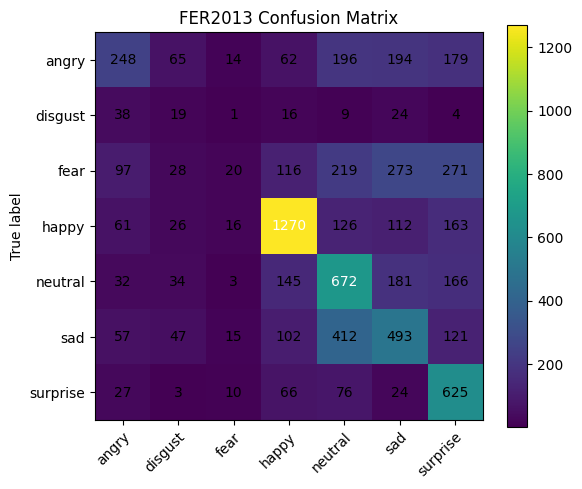

RAF-DB confusion matrix:
 [[  99   12    3   19    9   13    7]
 [  20   50    0   20   41   24    5]
 [  15    1   14   13    4    9   18]
 [   5    7    3 1071   51   31   17]
 [   4   20    1   41  501   79   34]
 [  11   25    2   33   59  341    7]
 [  11    6    0   12   40   11  249]]


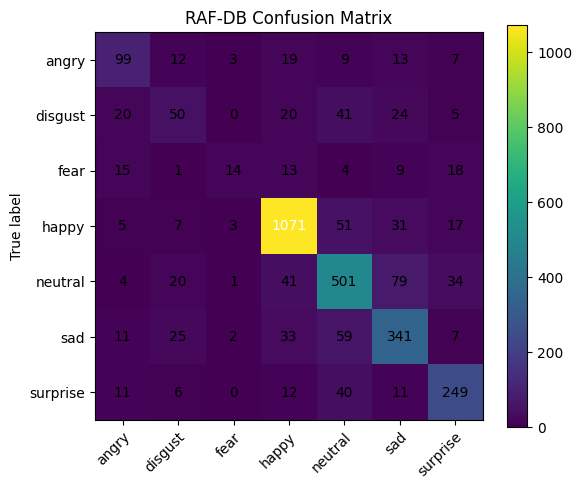

In [14]:
# Cell 12: Confusion matrices for FER and RAF

def plot_confusion(cm, labels, title):
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation="nearest")
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(len(labels)),
        yticks=np.arange(len(labels)),
        xticklabels=labels,
        yticklabels=labels,
        ylabel="True label",
        title=title,
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # write numbers in cells
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], "d"),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )
    plt.tight_layout()
    plt.show()


# FER2013 confusion matrix
fer_cm = confusion_matrix(fer_y_true, fer_y_pred)
print("FER2013 confusion matrix:\n", fer_cm)
plot_confusion(fer_cm, EMO_LABELS, "FER2013 Confusion Matrix")

# RAF-DB confusion matrix
raf_cm = confusion_matrix(raf_y_true, raf_y_pred)
print("RAF-DB confusion matrix:\n", raf_cm)
plot_confusion(raf_cm, EMO_LABELS, "RAF-DB Confusion Matrix")
